# Monte Carlo Guided Diffusion with Particles

This notebook implements the MCGDiff algorithm for the inverse problem of inpainting, utilizing the `particles` library for Sequential Monte Carlo (SMC) sampling. It mirrors the functionality of `mcgdiff_particles.py`.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import particles
from particles import state_space_models as ssm
from particles.core import FeynmanKac
from particles import distributions as dists
from particles import smc_samplers as ssp
from diffusers import UNet2DModel, DDPMScheduler
import torchvision.transforms as T
from tqdm.notebook import tqdm
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    import multiprocessing
    cores = multiprocessing.cpu_count()
    torch.set_num_threads(cores)
    print(f"Set torch num threads to {cores}")

print(f"Using device: {device}")

/home/smaug/Documents/MASTER/HiddenMarkovChain/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set torch num threads to 22
Using device: cpu


/home/smaug/Documents/MASTER/HiddenMarkovChain/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [4]:
dataset = CIFAR10(root="./data", train=False, download=True, transform=ToTensor())
image = dataset[0][0].unsqueeze(0).to(device)  # Use the first image in the dataset
print("Loaded CIFAR-10 image.")

Loaded CIFAR-10 image.


In [13]:
# Configuration
class Config:
    steps = 200          # Number of diffusion/SMC steps
    particles = 500      # Number of particles
    sigma = 3         # Observation noise sigma
    
config = Config()


In [14]:
# Helper Functions
from PIL import Image

def black_square(picture: torch.Tensor, n: int) -> torch.Tensor:
    """
    Add a black square of size (2n)x(2n) in the center of the picture.
    """
    if n <= 0:
        raise ValueError(f"n must be greater than 0 but got n={n}")

    pic = picture.clone()
    if pic.dim() == 2:
        H, W = pic.shape
        C = None
    elif pic.dim() == 3:
        C, H, W = pic.shape
    else:
        raise ValueError("picture must be 2D or 3D tensor")

    center_h, center_w = H // 2, W // 2
    h0 = center_h - n
    h1 = center_h + n
    w0 = center_w - n
    w1 = center_w + n

    if C is None:
        pic[h0:h1, w0:w1] = -1.0
    else:
        pic[:, h0:h1, w0:w1] = -1.0
    return pic

def load_image(path, size=256):
    try:
        img = Image.open(path).convert("RGB")
    except Exception as e:
        print(f"Could not load image at {path}, using dummy noise.")
        return torch.randn(1, 3, 256, 256).to(device)
        
    transform = T.Compose([
        T.Resize(size),
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize([0.5], [0.5]) # Map to [-1, 1]
    ])
    return transform(img).unsqueeze(0).to(device)

def show_tensor_image(tensor, title=None):
    if isinstance(tensor, np.ndarray):
        tensor = torch.from_numpy(tensor)
    tensor = tensor.to("cpu").detach()
    if tensor.dim() == 4:
        tensor = tensor.squeeze(0)
    
    img = (tensor + 1) / 2
    img = img.clamp(0, 1)
    plt.imshow(img.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')

In [15]:
# Load Model 
print("Loading model...")
model = UNet2DModel.from_pretrained(
    "google/ddpm-cifar10-32"
).to(device)

model.eval()
for p in model.parameters():
    p.requires_grad_(False)

scheduler = DDPMScheduler.from_pretrained(
    "google/ddpm-cifar10-32"
)


Loading model...


/home/smaug/Documents/MASTER/HiddenMarkovChain/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


In [16]:
def show(img, title=None):
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img)

    img = img.detach().cpu()

    # Handle (1, C, H, W) or (C, H, W)
    if img.dim() == 4:
        img = img.squeeze(0)
    elif img.dim() != 3:
        raise ValueError(f"Unexpected image shape: {img.shape}")

    img = (img + 1) / 2
    img = img.clamp(0, 1)
    img = img.permute(1, 2, 0)

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")


Loading observation...


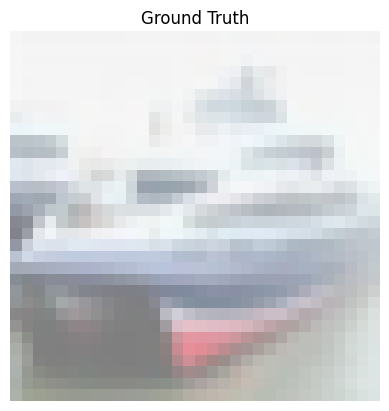

In [17]:

print(f"Loading observation...")

gt_image = dataset[1][0].unsqueeze(0).to(device)
show(gt_image, "Ground Truth")


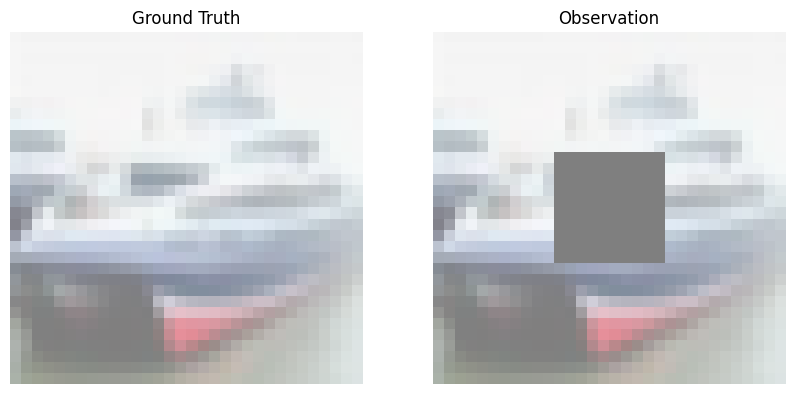

In [18]:

# Create Mask and Observation
n = 5 
mask = torch.ones_like(gt_image)
_, _, H, W = gt_image.shape
center_h, center_w = H // 2, W // 2
h0 = center_h - n
h1 = center_h + n
w0 = center_w - n
w1 = center_w + n

mask[:, :, h0:h1, w0:w1] = 0.0
observation = gt_image * mask 

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
show_tensor_image(gt_image, "Ground Truth")
plt.subplot(1, 2, 2)
show_tensor_image(observation, "Observation")
plt.show()

In [19]:
# Particles Classes

class DiffusionDist(dists.ProbDist):
    def __init__(self, model, scheduler, t_diff, x_t):
        self.model = model
        self.scheduler = scheduler
        self.t_diff = t_diff # Current diffusion timestep (scalar integer)
        self.x_t = x_t       # Current particles (N, C, H, W)

    def rvs(self, size=None):
        # size is typically N (number of particles). 
        # x_t should already have size N.
        
        self.model.eval()
        
        with torch.no_grad():
            x_t_tensor = torch.from_numpy(self.x_t).to(device).float()
            N = x_t_tensor.shape[0]
            
            # Predict noise
            t_tensor = torch.full((N,), self.t_diff, device=device, dtype=torch.long)
            model_output = self.model(x_t_tensor, t_tensor).sample
            
            # Compute previous image x_{t-1}
            output = self.scheduler.step(model_output, self.t_diff, x_t_tensor)
            prev_sample = output.prev_sample
            
            return prev_sample.cpu().numpy()

    def logpdf(self, x):
        return np.zeros(x.shape[0]) 

class DiffusionFeynmanKac(FeynmanKac):
    def __init__(self, model, scheduler, observation, mask, T_steps, img_shape):
        self.model = model
        self.scheduler = scheduler
        self.observation = observation.cpu().numpy() # (1, C, H, W)
        self.mask = mask.cpu().numpy()               # (1, C, H, W) - 1 for valid pixels, 0 for missing
        self.T_steps = T_steps
        self.img_shape = img_shape #(C, H, W)
    
    @property
    def T(self):
        return self.T_steps

    def M0(self, N):
        # x_T ~ N(0, I)
        return np.random.randn(N, *self.img_shape)

    def M(self, t, xp):
        # Transition from t to t+1
        current_diff_t = self.T_steps - 1 - t
        dist = DiffusionDist(self.model, self.scheduler, current_diff_t, xp)
        return dist.rvs()

    def logG(self, t, xp, x):
        # Weighting function.
        # Note: Base implementation, typically overridden by Spaced version
        return np.zeros(x.shape[0])

In [20]:
# Spaced Diffusion Implementation
scheduler.set_timesteps(num_inference_steps=config.steps)

class SpacedDiffusionFeynmanKac(DiffusionFeynmanKac):
    def M(self, t, xp):
        current_timestep = self.scheduler.timesteps[t]
        dist = DiffusionDist(self.model, self.scheduler, current_timestep, xp)
        return dist.rvs()

    def logG(self, t, xp, x):
        if t + 1 < len(self.scheduler.timesteps):
            current_timestep = self.scheduler.timesteps[t+1]
            self.model.eval()
            with torch.no_grad():
                x_tensor = torch.from_numpy(x).to(device).float()
                N = x.shape[0]
                t_tensor = torch.full((N,), current_timestep, device=device, dtype=torch.long)
                model_output = self.model(x_tensor, t_tensor).sample
                alpha_bar = self.scheduler.alphas_cumprod[current_timestep].to(device)
                # Estimate x0
                pred_x0 = (x_tensor - torch.sqrt(1 - alpha_bar) * model_output) / torch.sqrt(alpha_bar)
                pred_x0 = pred_x0.clamp(-1, 1)
        else:
            pred_x0 = torch.from_numpy(x).to(device).float()
        
        y_tensor = torch.from_numpy(self.observation).to(device).float()
        mask_tensor = torch.from_numpy(self.mask).to(device).float()
        
        diff = (pred_x0 - y_tensor) * mask_tensor
        num_obs = mask_tensor.sum(dim=(1,2,3))
        mse = torch.sum(diff**2, dim=(1,2,3)) / (num_obs + 1e-8)
        log_weights = - mse / (2 * config.sigma**2)
        return log_weights.cpu().numpy()

In [ ]:
# setup model
fk_model = SpacedDiffusionFeynmanKac(
    model=model, 
    scheduler=scheduler, 
    observation=observation, 
    mask=mask, 
    T_steps=len(scheduler.timesteps), 
    img_shape=gt_image.shape[1:]
)

# Run SMC
print(f"Running SMC with {config.particles} particles and {config.steps} steps...")
alg = particles.SMC(
    fk=fk_model,
    N=config.particles,
    resampling="systematic",
    ESSrmin=1.0,   
    verbose=True
)
alg.run()

Running SMC with 500 particles and 200 steps...
t=0: resample:False, ESS (end of iter)=499.95
t=1: resample:False, ESS (end of iter)=499.80
t=2: resample:False, ESS (end of iter)=499.58
t=3: resample:False, ESS (end of iter)=499.25
t=4: resample:False, ESS (end of iter)=498.83
t=5: resample:False, ESS (end of iter)=498.36
t=6: resample:False, ESS (end of iter)=497.82


KeyboardInterrupt: 

In [27]:
print("alg.X type:", type(alg.X))
print("alg.X len:", len(alg.X))
print("alg.X[-1].shape:", np.asarray(alg.X[-1]).shape)

print("alg.W[-1].shape:", np.asarray(alg.W[-1]).shape)


alg.X type: <class 'numpy.ndarray'>
alg.X len: 200
alg.X[-1].shape: (3, 32, 32)
alg.W[-1].shape: ()


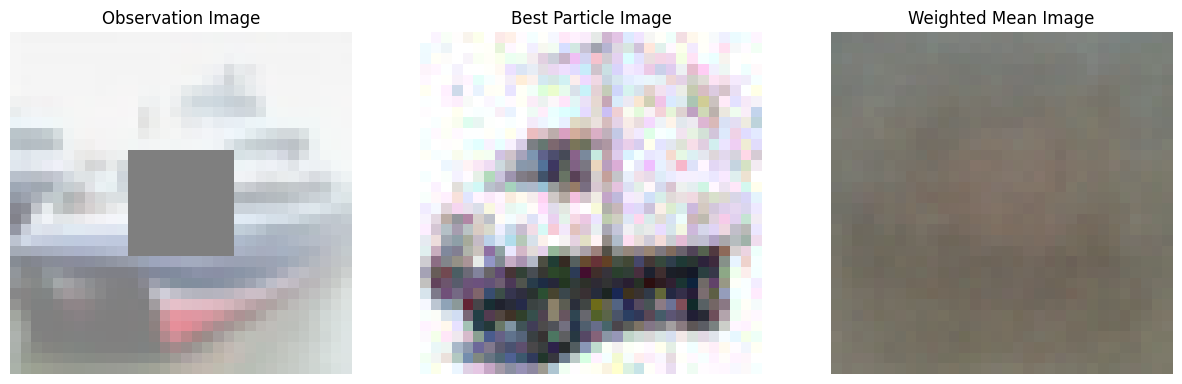

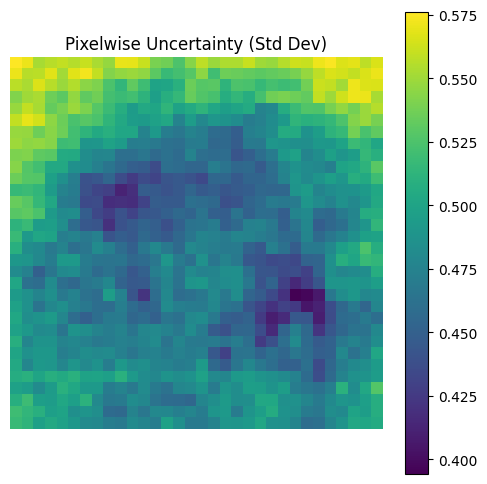

In [ ]:
# Compute Weighted Mean Image

final_particles = alg.X        # (N, C, H, W)
weights = alg.W                # (N,)
weights = weights / weights.sum()

mean_img = np.tensordot(weights, final_particles, axes=(0, 0))

best_idx = np.argmax(weights)
best_img = final_particles[best_idx]

# Show ground truth, observation and best particle
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
show(observation, "Observation Image")
plt.subplot(1, 3, 2)
show(best_img, "Best Particle Image")
plt.subplot(1, 3, 3)
show(mean_img, "Weighted Mean Image")
plt.show()  




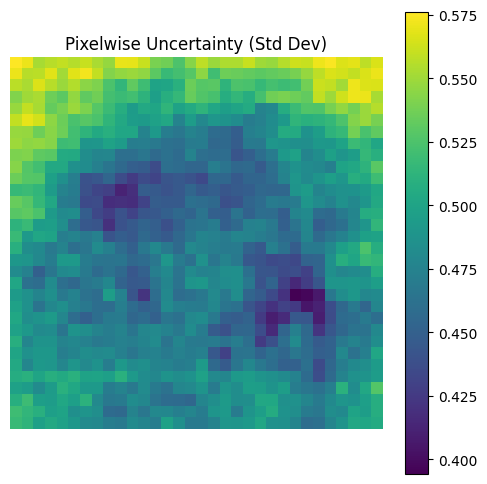

In [36]:

mean_img_expanded = mean_img[None, ...]  # (1, C, H, W)

variance = np.tensordot(
    weights,
    (final_particles - mean_img_expanded) ** 2,
    axes=(0, 0)
)

std_dev = np.sqrt(np.sum(variance, axis=0))  # (H, W)


# Uncertainty Analysis
mean_img_expanded = mean_img[np.newaxis, ...]
variance = np.average((final_particles - mean_img_expanded)**2, axis=0, weights=weights)
std_dev = np.sqrt(variance).mean(axis=0)

plt.figure(figsize=(6, 6))
plt.imshow(std_dev, cmap='viridis')
plt.title("Pixelwise Uncertainty (Std Dev)")
plt.colorbar()
plt.axis('off')
plt.show()